In [ ]:
!mkdir hamiltorch

In [ ]:
import numpy as np
import pandas as pd
import torch
import hamiltorch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

In [ ]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
class Net(nn.Module):

    def __init__(self, layer_sizes, informed_weights=None):
        super(Net, self).__init__()
        self.layer_sizes = layer_sizes
        self.layer_list = []

        self.l1 = nn.Linear(layer_sizes[0], layer_sizes[1], bias=True)
        self.l2 = nn.Linear(layer_sizes[1], layer_sizes[2], bias=True)

        # inverse variance tensors
        # TODO: change this
        std_weight = torch.Tensor([784., 12.]).to(device)
        std_bias = torch.Tensor([784., 12.]).to(device)

        if informed_weights==None:
            self.l1.weight.data = torch.randn(size=[layer_sizes[1], layer_sizes[0]], requires_grad=True, device=device) / torch.sqrt(std_weight[0])
            self.l2.weight.data = torch.randn(size=[layer_sizes[2], layer_sizes[1]], requires_grad=True, device=device) / torch.sqrt(std_weight[1])

            self.l2.bias.data = torch.randn(size=[1,layer_sizes[1]], requires_grad=True, device=device) / torch.sqrt(std_bias[0])
            self.l2.bias.data = torch.randn(size=[1,1], requires_grad=True, device=device) / torch.sqrt(std_bias[1])

        else:
            print("WOW! a well knowlegeable student")
            self.l1.weight = nn.Parameter(informed_weights[0])
            self.l2.weight = nn.Parameter(informed_weights[1])

            self.l1.bias = nn.Parameter(informed_weights[2])
            self.l2.bias = nn.Parameter(informed_weights[3])
            



    def forward(self, x):
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        return x

layer_sizes = [784,12,10]
net_teacher = Net(layer_sizes).to(device)

informed_weights = [net_teacher.l1.weight.detach().clone(), net_teacher.l2.weight.detach().clone(), net_teacher.l1.bias.detach().clone(), net_teacher.l2.bias.detach().clone()]
net_student_informed = Net(layer_sizes, informed_weights).to(device)
net_student_uninformed = Net(layer_sizes).to(device)

params_init = hamiltorch.util.flatten(net_teacher).to(device).clone()
print('Parameter size: ',params_init.shape[0])

WOW! a well knowlegeable student
Parameter size:  9541


In [ ]:
n=60000
n_test=5000

file_mnist=np.load("mnist.npz",allow_pickle=True)
X_train=torch.tensor(file_mnist["x_train"]) #use only half of the training set
X_test=torch.tensor(file_mnist['x_test']) #use only half of the test set
X_train=X_train.reshape([60000,28*28])[:n]/255
X_test=X_test.reshape([10000,28*28])[:n_test]/255
mean_X=torch.mean(X_train)
std_X=torch.std(X_train)

X_train=(X_train-mean_X)/std_X
X_test=(X_test-mean_X)/std_X
y_train=torch.tensor(file_mnist['y_train']).type(torch.long).flatten()[:n]
y_test=torch.tensor(file_mnist['y_test']).type(torch.long).flatten()[:n_test]

X_test = torch.Tensor(X_test).to(device)
y_test = torch.Tensor(y_test).to(device)
X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train).to(device)

In [ ]:
delta = 2
step_size = 1e-3
num_samples = 3000
L = 200
tau_first = 784.
tau_second = 12.
tau_out = 1/float(delta)/2

In [ ]:
W_shape = (layer_sizes[1],layer_sizes[0])
a_shape = (layer_sizes[2],layer_sizes[1])
W_bias_shape = (1,layer_sizes[1])
a_bias_shape = (1,layer_sizes[2])

informed_weights = [torch.ones(W_shape)*tau_first, torch.ones(a_shape)*tau_second, torch.ones(W_bias_shape)*tau_first, torch.ones(a_bias_shape)*tau_second]

# Net just to set the tau
net_tau = Net(layer_sizes, informed_weights)
tau_list = hamiltorch.util.flatten(net_tau).to(device).clone()

WOW! a well knowlegeable student


In [ ]:
std = 10
zero_weights = [torch.randn(W_shape, requires_grad=True, device=device)/std, torch.randn(a_shape, requires_grad=True, device=device)/std, torch.randn(W_bias_shape, requires_grad=True, device=device)/std, torch.randn(a_bias_shape, requires_grad=True, device=device)/std]
net_student_zero = Net(layer_sizes, zero_weights)

network = net_student_zero.to(device)

hamiltorch.set_random_seed(123)
params_init = hamiltorch.util.flatten(network).to(device).clone()
print('Parameter size: ',params_init.shape[0])
N_tr=X_train.shape[0]

params_hmc = hamiltorch.sample_model(network, X_train, y_train, model_loss='multi_class_linear_output',params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out,normalizing_const=N_tr, tau_list=tau_list)

W_mask_shape = [torch.ones(W_shape), torch.zeros(a_shape), torch.zeros(W_bias_shape), torch.zeros(a_bias_shape)]
a_mask_shape = [torch.zeros(W_shape), torch.ones(a_shape), torch.zeros(W_bias_shape), torch.zeros(a_bias_shape)]
W_bias_mask_shape = [torch.zeros(W_shape), torch.zeros(a_shape), torch.ones(W_bias_shape), torch.zeros(a_bias_shape)]
a_bias_mask_shape = [torch.zeros(W_shape), torch.zeros(a_shape), torch.zeros(W_bias_shape), torch.ones(a_bias_shape)]

# Nets just to extract the weights

net_W = Net(layer_sizes, W_mask_shape)
net_a = Net(layer_sizes, a_mask_shape)
net_W_bias = Net(layer_sizes, W_bias_mask_shape)
net_a_bias = Net(layer_sizes, a_bias_mask_shape)
W_mask = hamiltorch.util.flatten(net_W).data.to(device).clone()
a_mask = hamiltorch.util.flatten(net_a).data.to(device).clone()
W_bias_mask = hamiltorch.util.flatten(net_W_bias).data.to(device).clone()
a_bias_mask = hamiltorch.util.flatten(net_a_bias).data.to(device).clone()

W_norm_list = np.zeros(num_samples)
a_norm_list = np.zeros(num_samples)
W_bias_norm_list = np.zeros(num_samples)
a_bias_norm_list = np.zeros(num_samples)
for t in range(num_samples):
    W_norm_list[t] = torch.linalg.norm(params_hmc[t][W_mask==1])/np.sqrt(np.prod(W_shape))
    a_norm_list[t] = torch.linalg.norm(params_hmc[t][a_mask==1])/np.sqrt(np.prod(a_shape))
    W_bias_norm_list[t] = torch.linalg.norm(params_hmc[t][W_bias_mask==1])/np.sqrt(np.prod(W_bias_shape))
    a_bias_norm_list[t] = torch.linalg.norm(params_hmc[t][a_bias_mask==1])/np.sqrt(np.prod(a_bias_shape))

pred_list, log_prob_list = hamiltorch.predict_model(network, x=X_train, y=y_train, model_loss='multi_class_linear_output', samples=params_hmc[:], tau_out=tau_out, tau_list=tau_list)
accuracy_zero = (pred_list.data.detach().argmax(axis=2) == y_train.detach()).to("cpu").numpy().mean(axis=1)

pred_list, log_prob_list = hamiltorch.predict_model(network, x=X_test, y=y_test, model_loss='multi_class_linear_output', samples=params_hmc[:], tau_out=tau_out, tau_list=tau_list)
accuracy_zero_test = (pred_list.data.detach().argmax(axis=2) == y_test.detach()).to("cpu").numpy().mean(axis=1)

pd.DataFrame(data={"accuracy_train":accuracy_zero, "accuracy_test":accuracy_zero_test, "W_norm":W_norm_list, "a_norm":a_norm_list, "W_bias_norm":W_bias_norm_list, "a_bias_norm":a_bias_norm_list}).to_csv(f"accuracy_MLP_delta_{delta}.csv")
plt.plot(np.hstack([.1,.1,accuracy_zero]), label="Train")
plt.plot(np.hstack([.1,.1,accuracy_zero_test]), label="Test")

plt.xscale('log')
plt.xlabel("steps")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_MLP.png")
plt.show()

WOW! a well knowlegeable student
Parameter size:  9550


  6%|▌         | 174/3000 [59:59<16:10:28, 20.60s/it]

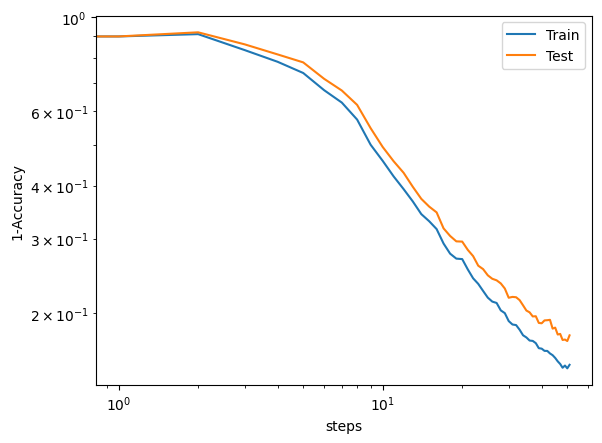

In [ ]:
plt.plot(1-np.hstack([.1,.1,accuracy_zero]), label="Train")
plt.plot(1-np.hstack([.1,.1,accuracy_zero_test]), label="Test")

plt.xscale('log')
plt.yscale("log")
plt.xlabel("steps")
plt.ylabel("1-Accuracy")
plt.legend()
plt.savefig(f"accuracy_MLP_delta_{delta}.png")
plt.show()

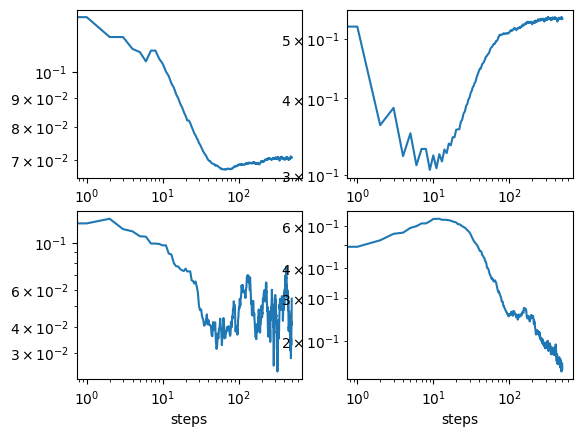

In [ ]:
plt.subplot(2,2,1)
plt.plot(W_norm_list[1:])
plt.xscale('log')
plt.yscale("log")

plt.subplot(2,2,2)
plt.plot(a_norm_list[1:])
plt.xscale('log')
plt.yscale("log")

plt.subplot(2,2,3)
plt.plot(W_bias_norm_list[1:])
plt.xscale('log')
plt.yscale("log")
plt.xlabel("steps")

plt.subplot(2,2,4)
plt.plot(a_bias_norm_list[1:])
plt.xscale('log')
plt.yscale("log")
plt.xlabel("steps")


plt.show()

In [ ]:
indices = np.unique(np.round(np.logspace(0,4,128)).astype(int))

indices

array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    16,    17,    18,
          20,    21,    23,    24,    26,    28,    30,    32,    35,
          38,    40,    43,    47,    50,    54,    58,    62,    67,
          72,    78,    83,    90,    96,   104,   111,   120,   129,
         139,   149,   160,   172,   185,   199,   214,   230,   248,
         266,   286,   308,   331,   356,   383,   411,   442,   476,
         511,   550,   591,   636,   683,   735,   790,   849,   913,
         982,  1056,  1135,  1221,  1313,  1411,  1517,  1632,  1754,
        1886,  2028,  2181,  2345,  2521,  2711,  2915,  3134,  3369,
        3623,  3895,  4188,  4503,  4842,  5206,  5598,  6019,  6472,
        6959,  7482,  8045,  8650,  9300, 10000])

In [ ]:
np.where(indices == 2345)[0][0]

84

In [ ]:
a = 1
b = 2


{"T":sampling, "m_list":m_list}

{'a': 1, 'b': 2}